<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-06-23-CNN_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification
* running fit with 50 epochs with early stopping with patience of 2
* also this notebook runs the CNN model twice - once with embedding of 32 (original), one with embedding of 300. At the end of the notebook, it prints a table to compare the two

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sns


import util.file_util as fu
import util.keras_util as ku
import util.plot_util as pu
import util.dict_util as du


%matplotlib inline
sns.set()


import logging
logging.basicConfig(level=logging.INFO)


Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
MODEL_NAME = "CNN_1layerEmbedding32"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"




In [4]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [6]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,48623501,R1G7J2VAMI4AEC,B00LBK7QBY,361030039,universal waterproof case joto cellphone dry b...,Wireless,5,0,0,good product please note not,good product please note not floating case do ...,2015-08-31
1,533148,R3Q4JAPXWCCJU7,B00W661MOO,360205932,car mount alpatronix mx101 universal charging ...,Wireless,5,0,0,great product holds phone place,great product holds phone place does not slip ...,2015-08-31
2,40266813,RJQWVO0QV2WQ4,B00USN9L0E,105913119,synthetic leather galaxy s6 sleeve thin,Wireless,5,0,0,exactly described,quality looks good prompt postage cannot argue...,2015-08-31
3,228806,R3RFPR7X60WN6C,B00YPAOKMU,564491128,jiake s6 5 0 inch unlocked smart phone quad co...,Wireless,5,0,0,powerful attractive really do love mode,works much like jiake phone love price great b...,2015-08-31
4,10866798,R3QL2UPH2B7YFT,B00O0S97SE,742788022,tfy universal car headrest mount holder portab...,Wireless,3,0,1,good enough,serves purpose loud whoever sitting seat attached,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

## Preprocessing

In [8]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(112043,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [12]:
train_sequences[:2]

[[20,
  24,
  16,
  11,
  1,
  21,
  2629,
  398,
  710,
  67,
  341,
  30,
  2290,
  153,
  140,
  13,
  1,
  28,
  186,
  396,
  20,
  16,
  93,
  370,
  1346,
  408,
  992],
 [99, 70, 31, 1, 168, 44, 1744, 452]]

In [13]:
test_sequences = t.texts_to_sequences(reviews_test)
test_sequences[:2]

[[9,
  608,
  2584,
  670,
  437,
  246,
  2,
  323,
  5,
  31,
  203,
  340,
  1414,
  643,
  342,
  147,
  242,
  272,
  54,
  128,
  278,
  908,
  27],
 [764,
  1621,
  4,
  783,
  2,
  11,
  1,
  149,
  260,
  3,
  914,
  243,
  249,
  2369,
  2,
  9,
  105,
  11,
  3,
  131,
  94,
  128,
  10,
  21]]

In [14]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=40788
Number of Documents=84032


### Sequence Normalization

Figure out max length of review and pad the rest so they are all the same length

In [15]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2864

In [16]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,1.120430e+05,1.120430e+05,112043.000000,112043.000000,112043.000000,112043.000000
mean,2.547598e+07,4.994998e+08,3.889078,0.912435,1.189704,26.322965
std,1.582173e+07,2.879968e+08,1.463196,10.304687,11.167197,47.248166
min,1.014100e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000
25%,1.231110e+07,2.493906e+08,3.000000,0.000000,0.000000,8.000000
50%,2.344848e+07,4.990693e+08,5.000000,0.000000,0.000000,15.000000
75%,4.040851e+07,7.481358e+08,5.000000,0.000000,1.000000,29.000000
max,5.309655e+07,9.999930e+08,5.000000,1447.000000,1524.000000,2864.000000


Looks like 95%+ of our reviews have 186 words or less. If we keep our sequence length to around 64 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [17]:
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
MAX_SEQUENCE_LENGTH

186

In [0]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
X_train[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [20]:
# this is our star rating column
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

**We are going to run this twice with identical networks. The first will have embedding size of 32. The second will have embedding size of 300. And we will compare results later*

# Building Our First Model with embedding of 32

In [0]:
EMBED_SIZE = 32
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [22]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0730 03:05:34.257769 140094294349696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 03:05:34.263904 140094294349696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 03:05:34.268427 140094294349696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 03:05:34.310024 140094294349696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 03:05:34.343013 140094294349696 deprecation_wrapp

In [23]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 32)           1305248   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 186, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2976)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               744250    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
Total params: 2,053,857
Trainable params: 2,053,857
Non-trainable params: 0
_________________________________________________________________


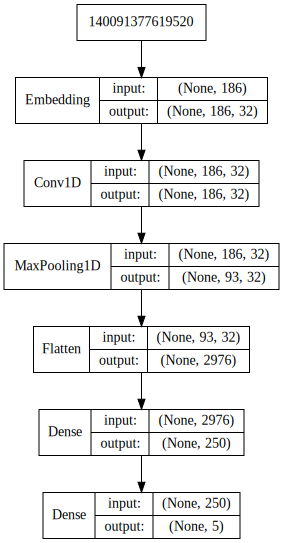

In [24]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# use our model wrapper the wrap the model so we can save things for later
mw = ku.ModelWrapper(model=model, 
                     name=MODEL_NAME, 
                     label_name=LABEL_COLUMN, 
                     data_file=DATA_FILE,
                     tokenizer=t,
                     embedding=EMBED_SIZE)


network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0730 03:05:34.569677 140094294349696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0730 03:05:34.646933 140094294349696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 6s 93us/step - loss: 0.9740 - acc: 0.6283 - val_loss: 0.8700 - val_acc: 0.6609
Epoch 2/50
67225/67225 [==============================] - 3s 43us/step - loss: 0.7716 - acc: 0.6984 - val_loss: 0.8516 - val_acc: 0.6680
Epoch 3/50
67225/67225 [==============================] - 3s 43us/step - loss: 0.6654 - acc: 0.7405 - val_loss: 0.9043 - val_acc: 0.6638
Epoch 4/50
67225/67225 [==============================] - 3s 43us/step - loss: 0.5619 - acc: 0.7854 - val_loss: 1.0253 - val_acc: 0.6487
Epoch 00004: early stopping


In [27]:
mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))


Running model.evaluate...
28011/28011 [==============================] - 1s 47us/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 65.18%


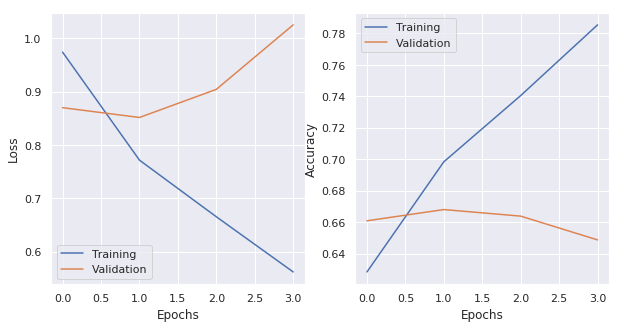

In [29]:

pu.plot_network_history(mw.network_history)

In [30]:
mw.confusion_matrix

array([[ 2629,   417,   411,   116,   395],
       [  567,   293,   484,   218,   309],
       [  281,   232,   722,   651,   645],
       [   78,    61,   417,  1422,  2774],
       [  121,    44,   232,  1300, 13192]])

In [31]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.72      0.66      0.69      3968
           2       0.28      0.16      0.20      1871
           3       0.32      0.29      0.30      2531
           4       0.38      0.30      0.34      4752
           5       0.76      0.89      0.82     14889

    accuracy                           0.65     28011
   macro avg       0.49      0.46      0.47     28011
weighted avg       0.62      0.65      0.63     28011



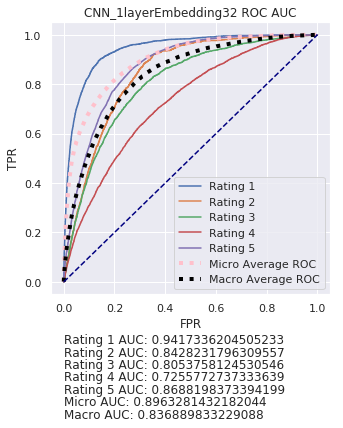

In [33]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

**Save off various files**

In [34]:
mw.save(DRIVE_DIR, append_report=True)

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_1layerEmbedding32-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_1layerEmbedding32-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_1layerEmbedding32-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


In [35]:
mw.get_report().to_df()

,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.651815,"{""1"": {""precision"": 0.7151795429815017, ""recal...","[[2629, 417, 411, 116, 395], [567, 293, 484, 2...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,32.0,0.31,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",1.01115,186.0,drive/My Drive/Springboard/capstone/models/ama...,CNN_1layerEmbedding32,<keras.callbacks.History object at 0x7f698f214...,0.31,"{""auc_1"": 0.9417336204505233, ""auc_2"": 0.84282...",success,2019-07-30 03:10:38,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.00352822...",84032.0,186.0,0.31


In [36]:
print(datetime.now())

2019-07-30 03:10:38.886539


# Second model of this with embedding of size 300 instead of 35

In [0]:
MODEL_NAME300 = "CNN_1layerEmbedding300"
EMBED_SIZE300 = 300
model300 = Sequential()
model300.add(Embedding(VOCAB_SIZE, EMBED_SIZE300, input_length=MAX_SEQUENCE_LENGTH))
model300.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model300.add(MaxPooling1D(pool_size=2))
model300.add(Flatten())
model300.add(Dense(250, activation='relu'))
model300.add(Dense(5, activation='softmax'))
model300.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [79]:
print(model300.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 186, 32)           28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 93, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2976)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               744250    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1255      
Total params: 13,011,037
Trainable params: 13,011,037
Non-trainable params: 0
________________________________________________________________

In [80]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# use our model wrapper the wrap the model so we can save things for later
mw300 = ku.ModelWrapper(model=model300, 
                     name=MODEL_NAME300, 
                     label_name=LABEL_COLUMN, 
                     data_file=DATA_FILE, 
                     tokenizer=t,
                     embedding=EMBED_SIZE300)

network_history300 = mw300.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 9s 132us/step - loss: 0.9369 - acc: 0.6409 - val_loss: 0.8570 - val_acc: 0.6668
Epoch 2/50
67225/67225 [==============================] - 8s 121us/step - loss: 0.7310 - acc: 0.7141 - val_loss: 0.8580 - val_acc: 0.6703
Epoch 3/50
67225/67225 [==============================] - 8s 122us/step - loss: 0.5760 - acc: 0.7776 - val_loss: 0.9664 - val_acc: 0.6563
Epoch 00003: early stopping


In [81]:
mw300.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw300.scores[1]*100))


Running model.evaluate...
28011/28011 [==============================] - 1s 52us/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 66.01%


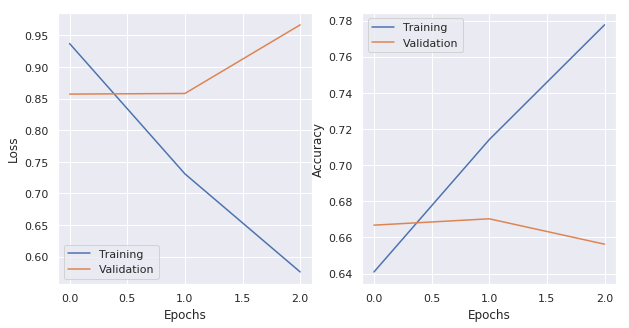

In [82]:
pu.plot_network_history(mw300.network_history)

In [83]:
mw300.confusion_matrix

array([[ 3013,   358,   281,    56,   260],
       [  799,   312,   421,   111,   228],
       [  448,   296,   747,   435,   605],
       [  143,   102,   571,  1272,  2664],
       [  240,    64,   292,  1147, 13146]])

In [84]:
print(mw300.classification_report)

              precision    recall  f1-score   support

           1       0.65      0.76      0.70      3968
           2       0.28      0.17      0.21      1871
           3       0.32      0.30      0.31      2531
           4       0.42      0.27      0.33      4752
           5       0.78      0.88      0.83     14889

    accuracy                           0.66     28011
   macro avg       0.49      0.47      0.47     28011
weighted avg       0.62      0.66      0.64     28011



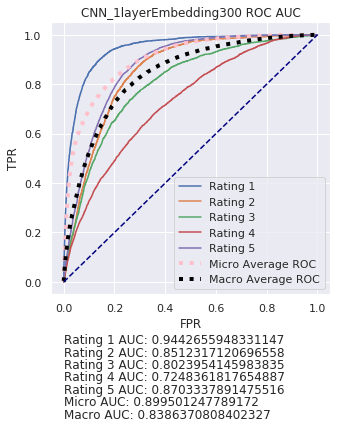

In [85]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw300.name, mw300.roc_auc, mw300.fpr, mw300.tpr)

In [86]:
mw300.save(DRIVE_DIR, append_report=True)
mw300.get_report().to_df()

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_1layerEmbedding300-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_1layerEmbedding300-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_1layerEmbedding300-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.660098,"{""1"": {""precision"": 0.6489338789575705, ""recal...","[[3013, 358, 281, 56, 260], [799, 312, 421, 11...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,0.51,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.946453,186.0,drive/My Drive/Springboard/capstone/models/ama...,CNN_1layerEmbedding300,<keras.callbacks.History object at 0x7f6862141...,0.51,"{""auc_1"": 0.9442655948331147, ""auc_2"": 0.85123...",success,2019-07-30 04:01:38,28011.0,186.0,drive/My Drive/Springboard/capstone/models/dl-...,"{""0"": [0.0, 0.00025201612903225806, 0.00756048...",84032.0,186.0,0.51


In [87]:
print(datetime.now())

2019-07-30 04:01:38.421940


In [88]:
# test report
loaded = pd.read_csv(mw300.report_file, quotechar="'")
loaded

,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.677591,"{""1"": {""precision"": 0.5852581521739131, ""recal...","[[3446, 71, 158, 50, 243], [1141, 90, 287, 120...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,32.59,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.835665,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_1layer,<keras.callbacks.History object at 0x7f5403610...,32.59,"{""auc_1"": 0.9527249533513878, ""auc_2"": 0.86096...",success,2019-07-30 01:46:31,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.0078125,...",84032.0,186.0,32.59
1,0.666845,"{""1"": {""precision"": 0.6141875505254648, ""recal...","[[3039, 150, 206, 95, 385], [892, 132, 293, 16...",review_body-word2vec5-111909-512-nolda-DNN_340...,word2vec,10.98,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.866301,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_340_batchnorm,<keras.callbacks.History object at 0x7f976c0f4...,10.98,"{""auc_1"": 0.9450905669619495, ""auc_2"": 0.84615...",success,2019-07-30 01:50:37,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00103225...",83931.0,512.0,10.98
2,0.679019,"{""1"": {""precision"": 0.6480066102045032, ""recal...","[[3137, 62, 476, 40, 253], [843, 60, 603, 132,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,8.79,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.823435,186.0,drive/My Drive/Springboard/capstone/models/ama...,biGRU_1layer_attention,<keras.callbacks.History object at 0x7f6df2f58...,8.79,"{""auc_1"": 0.9540099546947473, ""auc_2"": 0.86369...",success,2019-07-30 01:51:39,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.01058467...",84032.0,186.0,8.79
3,0.668990,"{""1"": {""precision"": 0.6134569850039463, ""recal...","[[3109, 147, 201, 93, 325], [911, 128, 310, 19...",review_body-word2vec5-111909-512-nolda-DNN_384...,word2vec,17.84,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846571,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_384_384,<keras.callbacks.History object at 0x7fab83bd1...,17.84,"{""auc_1"": 0.9488228396143968, ""auc_2"": 0.85419...",success,2019-07-30 01:58:04,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,17.84
4,0.668704,"{""1"": {""precision"": 0.5902151922015818, ""recal...","[[3209, 64, 239, 83, 280], [994, 75, 341, 179,...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,4.85,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.848801,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128,<keras.callbacks.History object at 0x7f87970b1...,4.85,"{""auc_1"": 0.9489704320035117, ""auc_2"": 0.85306...",success,2019-07-30 01:58:55,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00051612...",83931.0,512.0,4.85
5,0.667918,"{""1"": {""precision"": 0.5995067349649023, ""recal...","[[3160, 127, 223, 80, 285], [972, 119, 316, 18...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,6.92,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.148861137617...",0.846016,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128_batchnorm,<keras.callbacks.History object at 0x7f62cd50f...,6.92,"{""auc_1"": 0.949632140558062, ""auc_2"": 0.854176...",success,2019-07-30 02:08:19,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,6.92
6,0.676877,"{""1"": {""precision"":

# Compre the 2 models

In [89]:
print(mw.name)
print(mw.confusion_matrix)
print()
print(mw300.name)
print(mw300.confusion_matrix)


CNN_1layerEmbedding32
[[ 2629   417   411   116   395]
 [  567   293   484   218   309]
 [  281   232   722   651   645]
 [   78    61   417  1422  2774]
 [  121    44   232  1300 13192]]

CNN_1layerEmbedding300
[[ 3013   358   281    56   260]
 [  799   312   421   111   228]
 [  448   296   747   435   605]
 [  143   102   571  1272  2664]
 [  240    64   292  1147 13146]]


In [90]:
print(mw.name)
print(mw.classification_report)
print()
print(mw300.name)
print(mw300.classification_report)


CNN_1layerEmbedding32
              precision    recall  f1-score   support

           1       0.72      0.66      0.69      3968
           2       0.28      0.16      0.20      1871
           3       0.32      0.29      0.30      2531
           4       0.38      0.30      0.34      4752
           5       0.76      0.89      0.82     14889

    accuracy                           0.65     28011
   macro avg       0.49      0.46      0.47     28011
weighted avg       0.62      0.65      0.63     28011


CNN_1layerEmbedding300
              precision    recall  f1-score   support

           1       0.65      0.76      0.70      3968
           2       0.28      0.17      0.21      1871
           3       0.32      0.30      0.31      2531
           4       0.42      0.27      0.33      4752
           5       0.78      0.88      0.83     14889

    accuracy                           0.66     28011
   macro avg       0.49      0.47      0.47     28011
weighted avg       0.62      0.

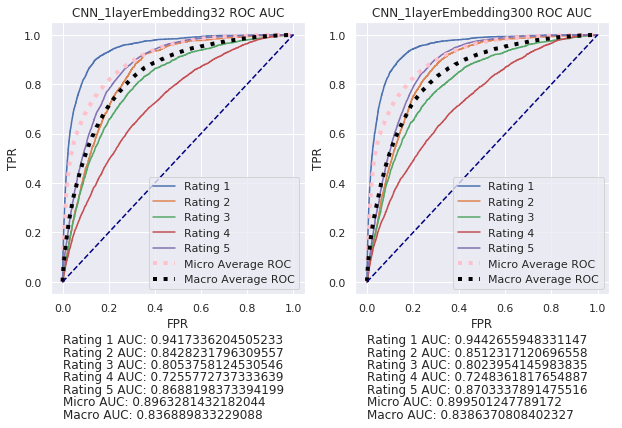

In [91]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2)

ax1  = fig.add_subplot(gs[0,0])
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

ax2  = fig.add_subplot(gs[0,1])
pu.plot_roc_auc(mw300.name, mw300.roc_auc, mw300.fpr, mw300.tpr)


# Conslusion

There is not a big difference between using embedding size of 32 or 300. However, for class 2 recall went up slightly by 1% meaning that it's better at identifying star rating 2's without much trade offs in other areas. 

When looking at Rating 4 - the recall went down to 3% however, precision sent up by 4% meaning that even though it's identify star rating 4 less, when it does, it's more likely that it is actually a Rating 4.

Considering the trade-offs, 300 embeddings are probably doing slightly better with the difficult classes